BitCoin in Neo4j
------------------

This notebook uploads bitcoin data from 2015 in Neo4j, and runs some queries on it.

To make sure the database is empty, the query in neo4j is:  

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
MATCH (n)  
OPTIONAL MATCH (n)-[r]-()  
DELETE n,r  
</div>

The bitcoin data files should be located in /var/lib/neo4j/import for linux, and probably in /neo4j/import for other OSes (and one needs to make sure to give permission to write in this folder, e.g. with chmod 666 for linux). The data we use are text files, one for each bitcoin block, where data has already been extracted.
Each row of the file contains 
* the transaction hash, 
* the transaction date,
* the number of inputs, then for each input, the previous transaction hash and the input's index within the previous transaction (which gives which output of this transaction it is), 
* the number of outputs, then for each output, the wallet address, the script (e.g. p2pk means pay to public key), and the amount in bitcoins.

Example:         
4148ad6d4d1ebd29283fdf1c79fd51448db0e2b0bce23ea7596e052c2a65bb35,    
Sat Dec 27 07:46:47 SGT 2014,      
1,239f5df2f49b649ab2c2606c5ee70efaddb75db8613022a229c9874d35ea8074,1,   
2,   
1GL9XqVfj3HBzK3xDg66zmWExQWkxWkJaV,P2PK,BTC 2.69532231,   
1NMueMBhhA1xLjy8v1G8akGLbd9fdkNjDh,P2PK,BTC 0.04   

Note: 0000000000000000000000000000000000000000000000000000000000000000 as the previous transaction hash means mining (creation of a bitcoin).

Upload
--------

We write several csv files and upload them using neo4j-import:
* tx.csv contains a list of the transaction hashes, with the transaction time
* out.csv contains a list of wallet addresses
The two above files contain the nodes, two types of them. The relations are given in:
* txtoout.csv contains the edges from transaction nodes to wallet addresses
* intotx.csv contains the edges from wallet address to transaction nodes

Reference: https://neo4j.com/docs/operations-manual/current/tutorial/import-tool/

The code below generates the csv files together with some stats, make sure writecsv = 1 (use 0 to just generate stats).

In [4]:
import csv
import numpy as np
import time
import datetime

txnb = 0
totalamount = 0
multinb = 0
perday = {}
cnt = 0

#if 1, write csv, if 0, only compute statistics
writecsv = 1

#to create a histogram of amounts
mybins = [0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,4,5,6,4000,10000]
myhist = np.zeros(len(mybins)-1, dtype='int32')
#create a calendar for time conversion
cal = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}

if writecsv == 1:
    #creates header files
    with open('/var/lib/neo4j/import/headers_tx.csv', 'w+') as headerfile1:
        headerfile1.write("txhash:ID,txdate:float,:LABEL")
    with open('/var/lib/neo4j/import/headers_out.csv', 'w+') as headerfile2:
        headerfile2.write("outid:ID,addr,:LABEL")
    with open('/var/lib/neo4j/import/headers_txtoout.csv', 'w+') as headerfile3:
        headerfile3.write(":START_ID,amount:float,:END_ID,:TYPE") 
    with open('/var/lib/neo4j/import/headers_intotx.csv', 'w+') as headerfile4:
        headerfile4.write(":START_ID,:END_ID,:TYPE")

    #creates files
    filetx = open('/var/lib/neo4j/import/tx.csv', 'w+')
    writertx = csv.writer(filetx)
    fileout = open('/var/lib/neo4j/import/out.csv', 'w+')
    writerout = csv.writer(fileout)
    filetoout = open('/var/lib/neo4j/import/txtoout.csv', 'w+')
    writertoout = csv.writer(filetoout)
    filefromin = open('/var/lib/neo4j/import/intotx.csv', 'w+')
    writerfromin = csv.writer(filefromin)

t = time.time()

for blockno in range(319,330): 
    #300 351
    #all: 212,408+1
    #AshleyMadison: 319-329 (Block height range: 369636-373196, time: 2015-08-13 02:34:45 to 2015-09-05 22:19:45 (UTC+0))
    if blockno % 10 == 2:   
        print('block:'), print(blockno)
    with open('/media/elise/linux-data/DataforAnalysis/BitCoin/Bitcoin2015/blk00%d.txt' %blockno, 'r') as csvfile:
        amounts = []
        reader = csv.reader(csvfile, delimiter=',')     
        for row in reader:
            
            #counts no of transactions
            txnb = txnb + 1
            #extracts the hash and the date
            txhash = row[0]
            txdate = row[1]
            #this removes the transaction time, and keeps the day
            txday = row[1][0:10]
            #transactions per day
            if txday in perday.keys():
                perday[txday] = perday[txday] + 1
            else:
                perday[txday] = 1
                  
            #extracts the input number     
            noinputs = int(row[2])
            colidx = 3
            inputs = []
            for col in range(noinputs):
                #extracts the data related to input
                inputs.append([row[colidx],row[colidx+1]])
                colidx = colidx + 2
            
            #extracts the output number 
            nooutputs = int(row[colidx])
            colidx = colidx + 1
            outputs = []
            #counts no of multi input transactions
            if noinputs > 1 and nooutputs > 2:
                multinb = multinb + 1
            for col in range(nooutputs):
                #extracts the data related to output
                outputs.append([row[colidx],row[colidx+2]])
                txamount = float(row[colidx+2].strip('BTC '))
                totalamount = totalamount + txamount
                amounts.append(txamount)
                colidx = colidx + 3   
                       
            if writecsv == 1:
                #write in csv 
                #SGT into epoch
                sd = txdate.split(" ")
                st = sd[3].split(":")
                txepoch = datetime.datetime(int(sd[5]),int(cal[sd[1]]),int(sd[2]),int(st[0]),int(st[1]),int(st[2])).timestamp()-7*60*60
                #write tx
                #txhash+","+str(txepoch)+",tx\r\n"
                writertx.writerow([txhash,str(txepoch),'tx'])
            
                for j in range(nooutputs): 
                    #write out
                    #txhash+"@"+str(j)+","+outputs[j][0]+",out\r\n"
                    writerout.writerow([txhash+"@"+str(j),outputs[j][0],'out'])
                    writertoout.writerow([txhash,outputs[j][1].strip('BTC '),txhash+"@"+str(j),'has output'])
                
                for i in range(noinputs):
                    #write in
                    #inputs[i][0]+"@"+inputs[i][1]+","+txhash+","+"is input \r\n"
                    #writerout.writerow([inputs[i][0]+"@"+inputs[i][1],'NKY','out'])
                    writerfromin.writerow([inputs[i][0]+"@"+inputs[i][1],txhash,'is input']) 
    
            if txnb % 2000 == 1:         
                #create a histogram from the given block    
                htemp, jnk = np.histogram(amounts, mybins)
                myhist += htemp
                amounts = []
                
print(time.time() - t)   

if writecsv == 1:
    filetx.close()
    fileout.close() 
    filetoout.close() 
    filefromin.close()

block:
322
116.74694991111755


Next, we perform the upload.

* The path for neo4j is /usr/bin/neo4j, this is to know how to call the import tool.
* Then the path for the files is relative, run this command within the import directory. 
* The database shoud not be started to run this command. 
* Make sure permissions are set right for debug.log and also for the databases directory.
* There should be no database for this to work, if there is one, go into data/databases and remove the directory graph.db (alternatively, rename it, in particular if one wishes to use several dbs).
* If more memory is needed, got into /etc/neo4j/neo4j.conf and change the memory parameters, e.g. increase dbms.memory.heap.intial_size = 1 GB and dmbs.memory.heap.max.size = 1 GB (use same no for both). For running the database after upload, set the original setting where both quantities are commented back.
* To check that the database is running fine, use /usr/bin/neo4j console.

Run the command below in a terminal.

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">    
/usr/bin/neo4j-admin import --nodes "headers_out.csv,out.csv" --ignore-duplicate-nodes  --nodes "headers_tx.csv,tx.csv"  --relationships "headers_txtoout.csv,txtoout.csv" --relationships "headers_intotx.csv,intotx.csv" --ignore-missing-nodes

</div>

Some Stats
----------

We just look at some stats.

Number of transactions:
2629791
Number of multi-input transactions:
218512
Total amount of transactions:
31922246.58596681


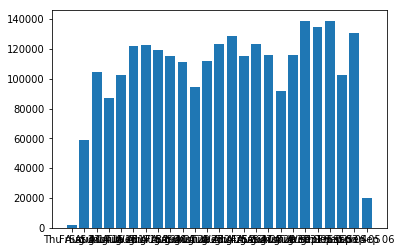

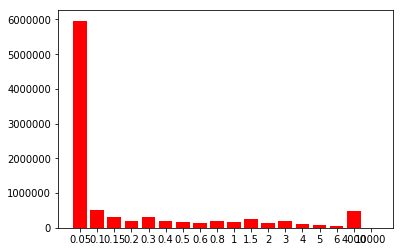

In [5]:
import matplotlib.pyplot as plt
import numpy as np

print('Number of transactions:'), print(txnb)   
print('Number of multi-input transactions:'), print(multinb)  
print('Total amount of transactions:'), print(totalamount)  

# save data for futher usage
# np.save('perday300-350.npy', perday) 
# np.save('myhist300-350.npy', myhist)

#plot the number of transactions per day
plt.bar(range(len(perday)), perday.values(), align='center')
plt.xticks(range(len(perday)), list(perday.keys()))
plt.show()

#plot the amounts
mybins = [0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,4,5,6,4000,10000]
plt.bar(range(len(myhist)), myhist, width = 0.8, color = 'red') 
bars = [str(x) for x in mybins[1:]]
plt.xticks(range(len(myhist)), bars)
plt.show()

Stats for the whole year, for information, are:
* Number of transactions:
46279742
* Number of multi-input transactions:
19656516
* Total amount of transactions:
553232801.0458639


Some queries
-------------

This counts the number of transactions.

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">

MATCH (n:tx) return count(n)

</div>

This returns neighbours at distance 1 from a given node.

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">

MATCH(n:out)-[*..1]-(m)     
WHERE n.outid='cd8c9ef95a9d69be95626ee0568fb7c000c1e08ea7d338fa50882875663ba249@0'     
RETURN n,m

</div>